# Imports

In [12]:
import numpy as np
import pandas as pd
import xml
import xml.etree.ElementTree as ET

# Parsing Util

In [13]:
def parse(element: xml.etree.ElementTree.Element):
    """
    Parses an xml element into a dictionary.
    """
    d = {}
    if not element.text or '\t' in element.text:
        for child in element:
            if child.tag in d:
                if type(d[child.tag]) is list:
                    d[child.tag].append(parse(child))
                else:
                    d[child.tag] = [d[child.tag], parse(child)]
            else:
                d[child.tag] = parse(child)
    else:
        return element.text
    
    return d

    

In [14]:
import os
names = list(set([name.split('.')[0] for name in os.listdir('data')]))

In [15]:
import random
import cv2

def sample_data(ids: list[tuple[str, dict, np.ndarray]]):
    """
    Parses the xml files and loads the images for the given ids
    """
    sample = []
    for id in ids:
        tree = xml.etree.ElementTree.parse(f'data/{id}.xml')
        root = tree.getroot()
        annotation = parse(root)
        image = cv2.imread(f'data/{id}.jpg')
        sample.append((id, image, annotation))
    
    return sample

# Visualization

In [16]:
from matplotlib import pyplot as plt
from matplotlib import patches

def visualize_sample(sample):
    """
    Plot the images with the bounding boxes for the given sample
    """
    num_samples = len(sample)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, (id, image, annotation) in enumerate(sample):
        print(annotation)
        ax = axes[i]
        ax.imshow(image)
        if "object" in annotation:
            if type(annotation["object"]) is not list:
                annotation["object"] = [annotation["object"]]
            for obj in annotation["object"]:
                x = int(obj["bndbox"]["xmin"])
                y = int(obj["bndbox"]["ymin"])
                w = int(obj["bndbox"]["xmax"]) - x
                h = int(obj["bndbox"]["ymax"]) - y
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                # label the box
                ax.text(x, y, obj["name"], color='r')
                ax.add_patch(rect)
        ax.set_title(id)
        ax.axis("off")


In [17]:
def visualize_random_sample(names: list[str], num_samples: int):
    """
    Visualizes a random sample of the given data
    """
    ids = random.sample(names, num_samples)
    sample = sample_data(ids)
    visualize_sample(sample)

{'folder': 'images_28_aprile', 'filename': 'upper_681992.jpg', 'path': '/home/francesco/Desktop/dataset_28_aprile/images_28_aprile/upper_681992.png', 'source': {'database': 'Unknown'}, 'size': {'width': '640', 'height': '480', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'robot', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '170', 'ymin': '234', 'xmax': '243', 'ymax': '396'}}, {'name': 'ball', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '186', 'ymin': '372', 'xmax': '219', 'ymax': '405'}}, {'name': 'goalpost', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '228', 'ymin': '322', 'xmax': '258', 'ymax': '353'}}, {'name': 'goalpost', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '433', 'ymin': '425', 'xmax': '500', 'ymax': '474'}}]}
{'folder': 'combinate', 'filename': 'upper_814020.jpg', 'path': '/home/vboxuser/Desktop/dataset_mf_1001/combinate/upper_814

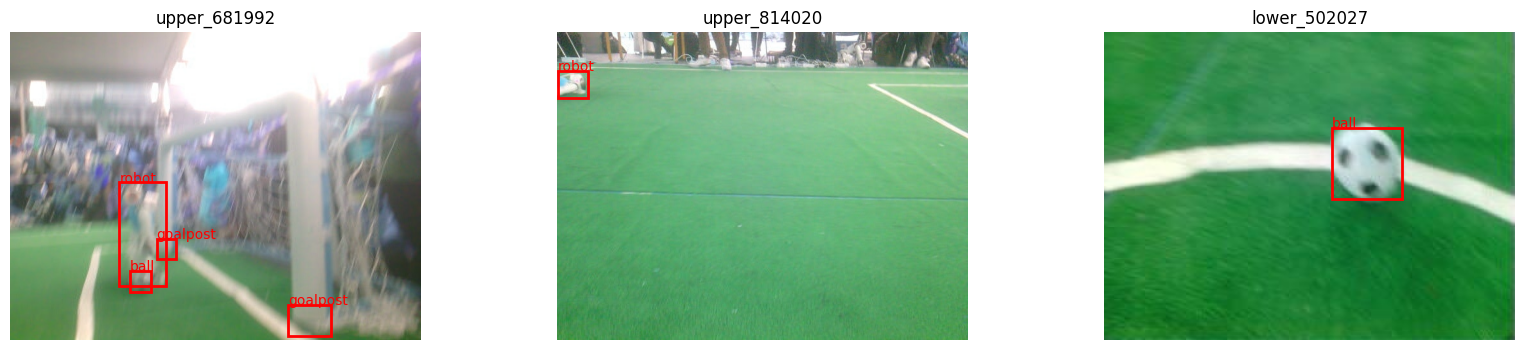

In [18]:
visualize_random_sample(names, 3)

# Line Segmentation 

In [68]:
def segment_line(image):
    """
    Segments the line on the field from the image using edge detection and Hough Line Transform.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    
    # Hough Line Transform to detect curves
    lines_curves = cv2.HoughLines(edges, 1, np.pi / 180, threshold=200)
    
    line_image = np.copy(image)
    
    if lines_curves is not None:
        for line in lines_curves:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Contour detection for curves
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.arcLength(contour, True) > 100:  # Filter small contours
            cv2.drawContours(line_image, [contour], -1, (0, 0, 255), 2)
    
    return line_image

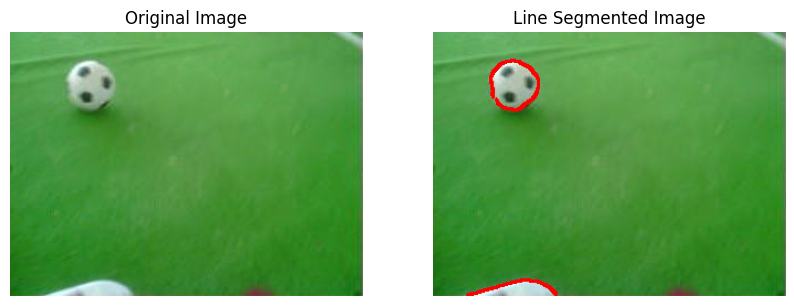

In [85]:
sample = sample_data(random.sample(names, 1))
id, image, annotation = sample[0]
line_segmented_image = segment_line(image)

# Display the original and line-segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Line Segmented Image")
plt.axis("off")

plt.show()